In [1]:
from tqdm import tqdm
import cv2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle

In [2]:
# Check GPU available
#tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Found GPU at: /device:GPU:0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9004175106029575139,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14988846299411002322
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8887142615982999092
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11235482010
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3658582123704949899
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [3]:
submission=pd.read_csv('./sample_submission.csv')
train=pd.read_csv('./train.csv')
test=pd.read_csv('./test.csv')

# train.head()
# test.head()
# submission.head()

# Load training set
train_img=[]
train_label=[]
path='./images'
for im in tqdm(train['image_id']):
    im=im+".jpg"
    final_path=os.path.join(path,im)
    img=cv2.imread(final_path)
    img=cv2.resize(img,(224,224))
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=img.astype('float32')
    train_img.append(img)

# Load test set
test_img=[]
path='./images'
for im in tqdm(test['image_id']):
    im=im+".jpg"
    final_path=os.path.join(path,im)
    img=cv2.imread(final_path)
    img=cv2.resize(img,(224,224))
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=img.astype(('float32'))
    test_img.append(img)

100%|██████████| 1821/1821 [01:17<00:00, 23.50it/s]


In [12]:
# Create training labels
train_label=train.loc[:,'healthy':'scab']
train_img=np.array(train_img)
test_img=np.array(test_img)
train_label=np.array(train_label)

print(train_label)

print("Training set size:",train_img.shape)
print("Training label size:",train_label.shape)

[[0 0 0 1]
 [0 1 0 0]
 [1 0 0 0]
 ...
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]]
Training set size: (1821, 224, 224, 3)
Training label size: (1821, 4)


In [13]:
# Image pre-processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_aug = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2,  
        horizontal_flip=True,  
        vertical_flip=False)  


In [14]:
# Train-val split 80-20 split. No K-fold at the moment
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_img, train_label, test_size=0.2, random_state=1)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(1456, 224, 224, 3)
(365, 224, 224, 3)
(1456, 4)
(365, 4)


In [15]:
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

from tensorflow.keras.callbacks import ReduceLROnPlateau

In [16]:
# VGG16-based model + Dense(256) + Dense(4)
tf.keras.backend.clear_session()
base_model=VGG16(include_top=False, weights='imagenet',input_shape=(224,224,3), pooling='avg')
model=Sequential()
model.add(base_model)
model.add(Dense(256,activation='relu'))
model.add(Dense(4,activation='softmax'))
base_model.trainable=False
model.compile( optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 14,847,044
Trainable params: 132,356
Non-trainable params: 14,714,688
_________________________________________________________________


In [17]:
BS = 16
EPOCHS = 5;# Originally 10 epochs
history_aug_firstpart = model.fit(data_aug.flow(X_train, y_train, batch_size = BS),
	validation_data=(X_val, y_val), 
	epochs=EPOCHS)

import tensorflow.keras as keras
base_model.trainable=True
model.compile(optimizer=keras.optimizers.Adam(1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
BS = 16
EPOCHS = 10;# Originally 30 epochs
history_aug_secondpart = model.fit(data_aug.flow(X_train, y_train, batch_size = BS),
	validation_data=(X_val, y_val), 
	epochs=EPOCHS)

  ...
    to  
  ['...']
Train for 91 steps, validate on 365 samples
Epoch 1/5
91/91 [==============================] - 25s 273ms/step - loss: 1.5248 - accuracy: 0.5955 - val_loss: 1.0504 - val_accuracy: 0.6767
Epoch 2/5
91/91 [==============================] - 24s 263ms/step - loss: 0.8573 - accuracy: 0.7129 - val_loss: 0.6638 - val_accuracy: 0.7890
Epoch 3/5
91/91 [==============================] - 24s 263ms/step - loss: 0.7423 - accuracy: 0.7534 - val_loss: 0.7198 - val_accuracy: 0.7425
Epoch 4/5
91/91 [==============================] - 24s 263ms/step - loss: 0.6794 - accuracy: 0.7637 - val_loss: 0.5771 - val_accuracy: 0.8000
Epoch 5/5
91/91 [==============================] - 24s 264ms/step - loss: 0.6600 - accuracy: 0.7706 - val_loss: 0.7137 - val_accuracy: 0.7671
  ...
    to  
  ['...']
Train for 91 steps, validate on 365 samples
Epoch 1/10
91/91 [==============================] - 45s 497ms/step - loss: 0.4292 - accuracy: 0.8613 - val_loss: 0.4501 - val_accuracy: 0.8795
Epoch 2/1

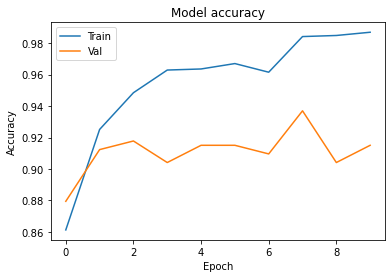

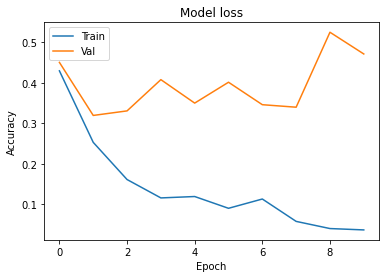

In [18]:
# Plot training loss and accuracy
history = history_aug_secondpart
plt.figure()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('VGG_finetune_accuracy.png', dpi=150)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.savefig('VGG_finetune_loss.png', dpi=150)



In [ ]:
# # Model visualization
# model.summary()
# layer_outputs = [layer.output for layer in model.layers[0].layers]

# visualize_model = Model(inputs = model.layers[0].layers[0].input, outputs=layer_outputs)


In [ ]:
# from numpy import expand_dims
# train_img.shape
# img_idx = 9;
# img = train_img[img_idx,:,:,:]
# img = expand_dims(img, axis=0)
# img.shape
# feature_maps = visualize_model.predict(img)
# feature_maps[1].shape

# # plot all 64 maps in an 8x8 squares
# plt.figure()
# from PIL import Image
# img_img = Image.fromarray(img[0,:,:,:].astype('uint8')).convert('RGB')
# plt.imshow(img_img)

# # plt.figure()
# idx = 1
# fig, axes = plt.subplots(nrows=4, ncols=16)
# for ax in axes.flat:
#     im = ax.imshow(feature_maps[17][0, :, :, idx-1], cmap='viridis')
#     ax.set_xticks([])
#     ax.set_yticks([])
#     idx+=1
# fig.colorbar(im, ax=axes.ravel().tolist())
# fig.set_figheight(8)
# fig.set_figwidth(32)

In [ ]:
# def featVisualization(visualize_model, img):
#     from numpy import expand_dims
#     from PIL import Image
#     img = expand_dims(img, axis=0)
#     img.shape
#     feature_maps = visualize_model.predict(img)
#     feature_maps[1].shape

#     # plot all 64 maps in an 8x8 squares
#     plt.figure()
#     img_img = Image.fromarray(img[0,:,:,:].astype('uint8')).convert('RGB')
#     plt.imshow(img_img)

#     # plt.figure()
#     idx = 1
#     fig, axes = plt.subplots(nrows=4, ncols=16)
#     for ax in axes.flat:
#         im = ax.imshow(feature_maps[17][0, :, :, idx-1], cmap='viridis')
#         ax.set_xticks([])
#         ax.set_yticks([])
#         idx+=1
#     fig.colorbar(im, ax=axes.ravel().tolist())
#     fig.set_figheight(8)
#     fig.set_figwidth(32)

In [ ]:
# img_idx = 9;
# img = train_img[img_idx,:,:,:]
# featVisualization(visualize_model, img)

In [ ]:
# Save training results
f = open("./results/VGG_history_aug_finetune.pkl","wb")
pickle.dump(history.history,f)
f.close()

In [ ]:
#  Load old training results
# new_history = pickle.load( open( "./results/VGG_history.pkl", "rb" ) )


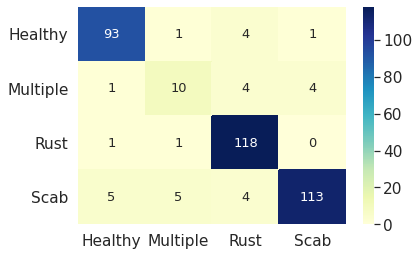

In [19]:
# submission
y_pred = model.predict(test_img)


submission.loc[:,'healthy':'scab'] = y_pred
submission.to_csv('submission_VGG_finetune.csv',index = False)

# PLot confusion matrix

val_pred = model.predict(X_val)

pred_index = np.argmax(val_pred,1)
y_val_index = np.argmax(y_val,1)
type(pred_index)

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_VGG_finetune = confusion_matrix(y_val_index, pred_index)
confusion = confusion_VGG_finetune
import seaborn as sn
df_cm = pd.DataFrame(confusion, index=["Healthy", "Multiple", "Rust", "Scab"], columns=["Healthy", "Multiple", "Rust", "Scab"])
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt="d", annot_kws={"size": 13})